# Exercise #5b - Actor-Critic

Welcome to the second policy gradient exercise. This time we are going to implemente the Actor-Critic algorithm. The actor is trained similar to the REINFORCE algorithm, but a critic is used to steer the training.

Let's start again with importing the necessary stuff.

In [1]:
import gymnasium
import numpy as np
from utils import run_environment, evaluate, discount

We will again be using the `LunarLander-v2` Gymnasium environment.

In [2]:
env = gymnasium.make('LunarLander-v2', render_mode='rgb_array')

## Actor

The Actor part in this algorithm is a policy estimator. In fact, we can use the same estimator as used in the previous exercise (REINFORCE).

Let's include it and create a new instance.

In [3]:
from estimator import PolicyEstimator
actor = PolicyEstimator(env)

Using cuda device


We are going to use the same random policy as the REINFORCE algorithm, that selects a random action from the predicted action probability distribution. You don't have to implement it again, since it is exactly the same.

In [4]:
def random_policy(observation):
    global env, actor
    action_probs = actor.predict(observation)
    action = np.random.choice(env.action_space.n, p=action_probs)
    return action

## Critic

The critic in this algorithm is a neural network that estimates state values (i.e. $v_\pi(s)$). Remember that this value represents the expected return when starting in state $s$ and following policy $\pi$. Again, we will use an already implemented estimator, this time the `StateValueEstimator` class from [`estimator.py`](estimator.py).

Let's create one and see what it predicts for a random observation.

In [5]:
from estimator import StateValueEstimator
critic = StateValueEstimator(env)

observation, _ = env.reset()
critic.predict(observation)

array([0.04493163], dtype=float32)

You should see that it returns only one value, which represents the expected return from this state, when following the learned policy. This estimator will be trained later, the current value is the result of random initialization.

## Advantages

In the previous exercise the policy estimator (actor in this case) was trained using the expected return $G_t$. Actions that had a high return got a higher probability than actions with a low return.

This approach works, but is quite unstable, at every episode the return is different (due to randomization). The targets for the estimator have a high variance. It is proven that the variance can be reduced by subtracting a baseline. In the Actor-Critic algorithm the prediction of the critic is used.

$$
A_t = G_{t} - V(S_t)
$$

In other words, use the actual return of the current time step and subtract the estimate of expected return of this state. This $A_t$ is also called advantage and it can be explained as follows. If the actual return received ($G_t$) is greater than the expected return $V(S_t)$, then the advantage will be positive and the actor should increase the probability of this action in this state. And, vice versa, if the actual return is lower than expected, then the probability should be decreased.

Let's compute the advantages in this helper function. First you should use `critic` to predict the state values for all the observations givens. Then subtract these state values from `returns` to get the advantages.

In [6]:
def compute_advantages(observations, returns):
    global critic
    ### START CODE ###
    
    # Compute state values for the current observations
    # using the state value estimator 'critic'    
    state_values = critic.predict(observations)
  
    # Compute the advantage
    advantages = returns - state_values
    
    ### END CODE ###
    return advantages

## Training

Again we will train the algorithm after every episode. Implement the next callback function.

First the rewards should be discounted with the `discount` function that we have implemented in the previous exercise, which represents the returns ($G_t$). Then the new `compute_advantages` function can be used to compute the advantages using those returns. Finally the two estimators can be trained using their `train` functions. The actor requires the `observations`, `actions` and `advantages`, the critic required the `observations` and `returns`.

In [7]:
def on_episode_end(episode, observations, actions, rewards, length, score):
    global actor, critic, gamma
    ### START CODE ###

    # Discount rewards to get the returns
    returns = discount(rewards, gamma)

    # Compute advantages
    advantages = compute_advantages(observations, returns)

    # Train the actor on the advantages and the critic on the returns
    actor.train(observations, actions, advantages)
    critic.train(observations, returns)
    
    ### END CODE ###

For this exercise we will use the same `gamma` as the previous exerices.

In [8]:
gamma = 0.99

Now, recreate the two estimators, so we can start fresh.

The training is now simply a call to the famous `run_environment` function.

Let's train for 500 episodes using the random policy and save the weights at the end. This can take a few minutes.

In [9]:
run_environment(env, 500, random_policy, on_episode_end=on_episode_end)
actor.save_weights('lunar-actor.pth')
critic.save_weights('lunar-critic.pth')

100%|██████████| 500/500 [03:57<00:00,  2.10it/s, avg_length=658.0, avg_score=-41.4] 


Time to evaluate the result.

## Evaluation

The Actor-Critic algorithm uses two estimators, but only the actor is needed for interaction with the environment. We can, like during training, use the same greedy policy as was used in the REINFORCE exercise.

In [10]:
def greedy_policy(observation):
    global actor
    action_probs = actor.predict(observation)
    return np.argmax(action_probs)

Let's see how well the actor performs after 500 episodes.

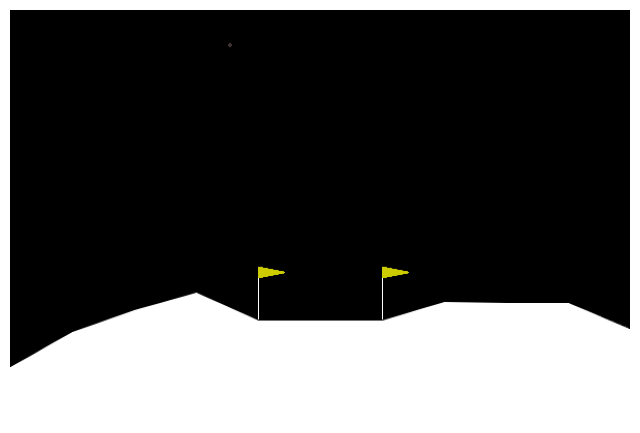

Episode length: 1000, return: -180.41634364625696
partially trained model: -180.4


In [11]:
actor.load_weights('lunar-actor.pth')
length, score = evaluate(env, greedy_policy)
print(f'partially trained model: {score:.1f}')

It should preform similar to the REINFORCE algorithm. It mostly keeps hovering without actually landing. The Actor-Critic did improve the training process a lot. That is mainly caused by determining the target values for training. We now need more samples (i.e. episodes) to get the critic trained before it can steer the actor in the right direction. But this algorithm is the start of a lot of the state-of-the-art algorithms. In the lecture you will see what can be done to improve the Actor-Critic algorithm.

If you let it run for 10000 episodes (>1 hour), then it will perform like this.

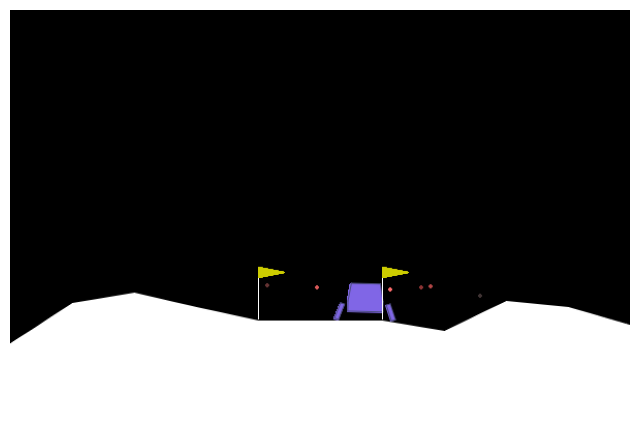

Episode length: 1000, return: 124.63338574105245
fully trained model: 124.6


In [12]:
actor.load_weights('trained/lunar-actor.pth')
length, score = evaluate(env, greedy_policy)
print(f'fully trained model: {score:.1f}')

## Conclusion

That's it! The Actor-Critic algorithm is basically a combination is parts you already saw in the previous exercise. This model is the start of more efficient algorithms. Let's take a look at those and then see what we can implement.